### imports

In [1]:
from theano.sandbox import cuda
cuda.use('gpu0')

In [2]:
cuda.active_device_name()

'Tesla K80'

In [2]:

from sklearn.preprocessing import LabelEncoder
#import cv2
import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from collections import Counter


In [3]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [4]:
#path = "data/fish/sample/"
path = "/mnt/kaggle_fisherman/"
batch_size=64

### functions

In [5]:
def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        #img = cv2.imread(path, 0)
        pass
    elif color_type == 3:
        img = Image.open(path)
    # Reduce size
    resized = img.resize((img_cols, img_rows))
    return resized

In [6]:
def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []

    #driver_data = get_driver_data()

    print('Read train images')
    '''
    for j in unique_fish_cats:
        print('Load folder {}'.format(j))
        path = os.path.join( j, '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = np.array(get_im_cv2(fl, img_rows, img_cols, color_type))

            X_train.append(img)
            y_train.append(j)
            #driver_id.append(driver_data[flbase])
    '''
    for fl in e:
        #flbase = os.path.basename(fl)
        img = np.array(get_im_cv2(fl, img_rows, img_cols, color_type))

        X_train.append(img)
        y_train.append(fl.split('/')[0])
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, 


In [7]:
train[1]

NameError: name 'train' is not defined

In [8]:
def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    path = os.path.join( 'unknown/*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))

    return X_test, X_test_id

In [9]:
def one_hot_label_encode(y):

    le=LabelEncoder()

    oh=OneHotEncoder()

    int_classes=le.fit_transform(y)
    oh_classes=oh.fit_transform(int_classes.reshape(int_classes.shape[0],1)) #this reshape is bcz the one hot encoder likes this format
    return oh_classes

## init

In [10]:
%cd /mnt/kaggle_fisherman//train

/mnt/kaggle_fisherman/train


In [11]:
#load all files, be in train folder
e = glob('*/*.jpg')
len(e)

3777

In [12]:
#fish categories list
fish_cats=[i.split('/')[0] for i in e]

In [13]:
unique_fish_cats=np.unique(fish_cats)

In [14]:
#get list of image sizes
sizes = [PIL.Image.open(path+'train/'+f).size for f in e]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [15]:
train_ratios=[Counter(sizes)[size] for  size in Counter(sizes)]

In [16]:
size_id_list=[size2id[size] for size in sizes]
size_id_list_2=[size2id[size] for size in sizes]

In [17]:
import glob

%cd /mnt/kaggle_fisherman/train
img_rows, img_cols, color_type=224,224,3
train=load_train(img_rows, img_cols, color_type)

/mnt/kaggle_fisherman/train
Read train images
Unique drivers: 0
[]


In [18]:
test=load_test(img_rows, img_cols, color_type)
test_array=np.array(test[0])

Read test images


In [19]:
train_array=np.moveaxis(train[0], -1, 1)
train_array.shape

(3777, 3, 224, 224)

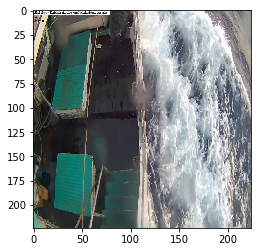

In [20]:
plt.imshow(np.moveaxis(train_array[5], 0,-1))

In [21]:
y=fish_cats

In [22]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
logo.get_n_splits(train, y, size_id_list)

10

In [23]:
oh_classes=one_hot_label_encode(y)

In [24]:
oh_classes_array=oh_classes.toarray()

In [25]:
np.random.shuffle(size_id_list_2)

In [26]:
size_id_list==size_id_list_2

False

In [27]:
i=1
stop=1
for train_index, test_index in logo.split(train_array, y, size_id_list):
    Xtrain, Xval, ytrain,yval  = train_array[train_index], train_array[test_index], oh_classes_array[train_index], oh_classes_array[test_index]
    if i==stop:
        break
    i+=1


In [186]:
len(yval)

598

## work

In [30]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)
#model.compile(optimizer=Adam(1e-3),loss='categorical_crossentropy', metrics=['accuracy'])

/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


## do more serious work

In [31]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [32]:
conv_model = Sequential(conv_layers)

In [33]:
conv_feat = conv_model.predict(Xtrain)
conv_val_feat = conv_model.predict(Xval)

KeyboardInterrupt: 

In [191]:
conv_feat_all = conv_model.predict(train_array)

In [193]:
save_array(model_path+'results/conv_val_feat.dat', conv_val_feat)
save_array(model_path+'results/conv_feat.dat', conv_feat)

In [36]:
conv_val_feat=load_array(model_path+'results/conv_val_feat.dat')
conv_feat=load_array(model_path+'results/conv_feat.dat')

In [37]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [38]:
p=0.6

In [39]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
bn_model.fit(conv_feat,ytrain,batch_size=64,nb_epoch=4,validation_data=(conv_val_feat,yval))

Train on 3179 samples, validate on 598 samples
Epoch 1/4
3179/3179 [==============================] - 2s - loss: 1.0469 - acc: 0.6914 - val_loss: 4.6930 - val_acc: 0.1990

In [176]:
bn_model.optimizer.lr = 1e-4

In [177]:

bn_model.fit(conv_feat,ytrain,batch_size=64,nb_epoch=7,validation_data=(conv_val_feat,yval))

Train on 2656 samples, validate on 1464 samples
Epoch 1/7
2656/2656 [==============================] - 1s - loss: 0.5641 - acc: 0.8038 - val_loss: 0.4119 - val_acc: 0.8770

## multi output

In [41]:
anno_classes=unique_fish_cats

In [42]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'shark', 'yft']

In [43]:
anno_classes_id = ['1', '2', '3', '4', '5', '6']

In [44]:
anno_classes=[anno.lower() for anno in anno_classes]

In [45]:
model_path='/mnt/kaggle_fisherman/'

In [46]:
import ujson as json
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(model_path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [47]:
labels=pd.read_json(model_path+'/annos/bet_labels.json')
img_filename = labels.iloc[0,2]
l1 = pd.DataFrame((labels[labels.filename==img_filename].annotations).iloc[0])

In [48]:
filenames=np.array(e)[train_index] #train index is the one group out, train indixes is the stratifeid
val_filenames=np.array(e)[test_index]

In [49]:
len(e)

3777

In [50]:
raw_filenames = [f.split('/')[-1] for f in filenames]
#raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [51]:
len(bb_json)

2998

In [52]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [53]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [54]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [55]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [56]:
train_sizes,raw_val_sizes=np.array(sizes)[train_index],np.array(sizes)[test_index]

In [57]:
len(train_array)

3777

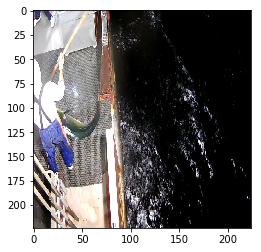

In [58]:
plt.imshow(np.moveaxis(train_array[563], 0, -1))

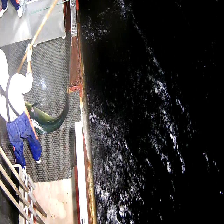

In [59]:
Image.open(e[563]).resize([224,224])

In [60]:
#need sizes from multi inputs
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, train_sizes)],).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

In [61]:
trn_bbox[550]

array([ 119.7778,   75.95  ,   93.1   ,   38.2667], dtype=float32)

In [104]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = trn_bbox[i]
    plot(Xtrain[i])
    plt.gca().add_patch(create_rect(bb))
    
def show_bb_val(i):
    bb = val_bbox[i]
    plot(Xval[i])
    plt.gca().add_patch(create_rect(bb))

def show_bb_val_pred(i):
    bb = val_preds[i]
    plot(Xval[i])
    plt.gca().add_patch(create_rect(bb))
    


In [87]:
val_preds[1][120]

array([  2.0115e-03,   1.7591e-05,   6.8785e-06,   5.3536e-06,   9.9789e-01,   9.9257e-06,
         5.5123e-05,   7.7491e-06], dtype=float32)

In [70]:
sum(yval)

array([ 303.,    7.,   24.,    0.,   64.,   10.,   27.,  163.])

In [63]:
conv_layers[-1].output_shape

(None, 512, 14, 14)

In [91]:
p=0.5

In [110]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [111]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],loss_weights=[.001, 1.])

In [112]:
model.fit(conv_feat, [trn_bbox, ytrain], batch_size=batch_size, nb_epoch=3, validation_data=(conv_val_feat, [val_bbox, yval]))

Train on 3179 samples, validate on 598 samples
Epoch 1/3
3179/3179 [==============================] - 2s - loss: 6.2460 - bb_loss: 4585.0491 - class_loss: 1.6610 - bb_acc: 0.3067 - class_acc: 0.5049 - val_loss: 10.0726 - val_bb_loss: 4440.9934 - val_class_loss: 5.6316 - val_bb_acc: 0.1003 - val_class_acc: 0.0753

In [97]:
#detection model with only bboxes
model = Model([inp], [x_bb])
model.compile(Adam(lr=0.001), loss=['mse'])

In [101]:
model.fit(conv_feat, [trn_bbox, ], batch_size=batch_size, nb_epoch=3, validation_data=(conv_val_feat, [val_bbox]))

Train on 3179 samples, validate on 598 samples
Epoch 1/3
3179/3179 [==============================] - 2s - loss: 345.8997 - val_loss: 3401.5609

In [73]:
model.optimizer.lr = 1e-5

In [74]:
model.fit(conv_feat, [trn_bbox, ytrain], batch_size=batch_size, nb_epoch=10, validation_data=(conv_val_feat, [val_bbox, yval]))

Train on 3179 samples, validate on 598 samples
Epoch 1/10
3179/3179 [==============================] - 2s - loss: 3.1326 - bb_loss: 3042.2462 - class_loss: 0.0903 - bb_acc: 0.5429 - class_acc: 0.9802 - val_loss: 12.2337 - val_bb_loss: 6171.7129 - val_class_loss: 6.0620 - val_bb_acc: 0.1137 - val_class_acc: 0.2074

In [102]:
val_preds=model.predict(conv_val_feat)

In [106]:
val_preds[120]

array([ -3.0976,  -5.235 , -10.8209,  -5.0356], dtype=float32)

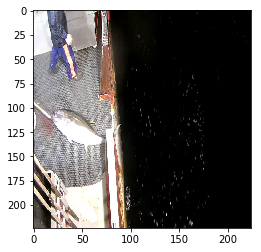

In [105]:
show_bb_val_pred(120)

## larger size

In [22]:
import glob
img_rows, img_cols, color_type=360,640,3
train=load_train(img_rows, img_cols, color_type)

Read train images
Load folder ALB
Load folder BET
Load folder DOL
Load folder LAG
Load folder NoF
Load folder OTHER
Load folder SHARK
Load folder YFT
Unique drivers: 0
[]


In [24]:
train_array=np.array(train[0])
new_train_array=np.zeros([3777,3,360,640])
new_train_array[:,0,:,:]=train_array[:,:,:,0]
new_train_array[:,1,:,:]=train_array[:,:,:,1]
new_train_array[:,2,:,:]=train_array[:,:,:,2]
train_array=new_train_array

In [39]:
[t/1001 for t in test_ratios]

[0.14785214785214784,
 0.003996003996003996,
 0.002997002997002997,
 0.01098901098901099,
 0.04495504495504495,
 0.6053946053946054,
 0.056943056943056944,
 0.0979020979020979,
 0.006993006993006993,
 0.02097902097902098]

In [37]:
[t/3777 for t in train_ratios]

[0.1583267143235372,
 0.007148530579825258,
 0.009266613714588298,
 0.008207572147206778,
 0.05242255758538523,
 0.5755890918718559,
 0.05824728620598359,
 0.10458035477892508,
 0.010325655281969817,
 0.015885623510722795]

In [97]:
sum=0
cum_train_ratios=[]
for i in train_ratios:
    cum_train_ratios.append(sum)
    sum+=i

In [163]:
#make_stratified_by test
val_indices=np.array([])
for group_size,test_group_size,cumsum in zip(train_ratios,test_ratios,cum_train_ratios):
    #print (group_size,test_group_size,int(group_size*(test_group_size/1000)))
    val_indices=np.append(val_indices,np.random.choice(group_size,int(group_size*(test_group_size/1000)))+cumsum)

val_indices=val_indices.astype(int)

In [159]:
len(val_indices)

1464

In [162]:
train_indices=[i not in val_indices  for i in np.arange(3777)]

In [138]:
np.arange(3777)[val_indices.astype(int)]

array([ 257,   91,  214, ..., 3721, 3771, 3741])

In [135]:
np.array([1,2,3,4])[[1,2]]

array([4, 3])

In [32]:
test=load_test(img_rows, img_cols, color_type)
test_array=np.array(test[0])

Read test images
Read 100 images from 1000
Read 200 images from 1000
Read 300 images from 1000
Read 400 images from 1000
Read 500 images from 1000
Read 600 images from 1000
Read 700 images from 1000
Read 800 images from 1000
Read 900 images from 1000
Read 1000 images from 1000


In [164]:
Xtrain, Xval, ytrain,yval  = train_array[train_indices], train_array[val_indices], oh_classes_array[train_indices], oh_classes_array[val_indices]